# Turkish News

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import json
import pickle

from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report

from src.utils import get_project_config
from src.utils import missing_values
import time
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')
%matplotlib inline

<Figure size 800x600 with 0 Axes>

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

#### Set Path and Constant Values

In [4]:
# Set Constants
ROOT_PATH = os.getcwd()
CFG_PATH = os.path.join(ROOT_PATH, 'cfg')
DATA_PATH = os.path.join(ROOT_PATH, 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
EMBEDDING_DATA_PATH = os.path.join(DATA_PATH, 'embedding')
MDL_STATS_PATH = os.path.join(ROOT_PATH, 'model_stats')

os.makedirs(RAW_DATA_PATH, exist_ok=True)
os.makedirs(EMBEDDING_DATA_PATH, exist_ok=True)
os.makedirs(MDL_STATS_PATH, exist_ok=True)

### Embedding Models

In [5]:
embedding_models = [
    'sentence-transformers/all-MiniLM-L12-v2',
    "jinaai/jina-embeddings-v3",
    "intfloat/multilingual-e5-large-instruct",
    "BAAI/bge-m3",
    "thenlper/gte-large"
]

embedding_models_dict = {
    "All Mini LM L12 v2": "sentence-transformers/all-MiniLM-L12-v2",
    "Jina Embeddings v3": "jinaai/jina-embeddings-v3",
    "Int Float Multilingual E5 Large Instruct": "intfloat/multilingual-e5-large-instruct",
    "BAAI BGE M3": "BAAI/bge-m3",
    "Thenlper Gte Large" : "thenlper/gte-large"
}

## Import Dataset: Turkish News Datasets

In [6]:
df_news_data = pd.read_csv(os.path.join(RAW_DATA_PATH, "tr_news_data.csv.gz"), compression='gzip')
df_news_data[['Ozet', 'Kategori']].head(3)

,Ozet,Kategori
0,"Buckingham Sarayı’ndan, Atatürk’ün özel koleksiyonuna kadar kıymetli birçok halı Aksaray’ın Sultanhanı ilçesinde tamir ediliyor. Ünü ülke sınırlarını aşan ilçe, halı tamiri işinde dünyanın en gözde adresi...",Yaşam
1,"Malatya'da trambüse çarpan hafif ticari araçtaki 3 yaşındaki çocuk öldü, 2 kişi yaralandı.",Türkiye
2,"Yargıtay Ceza Genel Kurulu, Ankara Seferberlik Bölge Başkanlığının ""kozmik odaları""nda günlerce süren aramalarla devam eden soruşturmada görev alan hakim ve savcılara verilen cezaları onadı.",Gündem


In [7]:
df_emb_data_1 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "news_sentence-transformers__all-MiniLM-L12-v2_embeddings.csv.gz"), compression='gzip')
df_emb_data_1.head(3)

,Ozet,Kategori,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,embedding_101,embedding_102,embedding_103,embedding_104,embedding_105,embedding_106,embedding_107,embedding_108,embedding_109,embedding_110,embedding_111,embedding_112,embedding_113,embedding_114,embedding_115,embedding_116,embedding_117,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,embedding_128,embedding_129,embedding_130,embedding_131,embedding_132,embedding_133,embedding_134,embedding_135,embedding_136,embedding_137,embedding_138,embedding_139,embedding_140,embedding_141,embedding_142,embedding_143,embedding_144,embedding_145,embedding_146,embedding_147,embedding_148,embedding_149,embedding_150,embedding_151,embedding_152,embedding_153,embedding_154,embedding_155,embedding_156,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166,embedding_167,embedding_168,embedding_169,embedding_170,embedding_171,embedding_172,embedding_173,embedding_174,embedding_175,embedding_176,embedding_177,embedding_178,embedding_179,embedding_180,embedding_181,embedding_182,embedding_183,embedding_184,embedding_185,embedding_186,embedding_187,embedding_188,embedding_189,embedding_190,embedding_191,embedding_192,embedding_193,embedding_194,embedding_195,embedding_196,embedding_197,embedding_198,embedding_199,embedding_200,embedding_201,embedding_202,embedding_203,embedding_204,embedding_205,embedding_206,embedding_207,embedding_208,embedding_209,embedding_210,embedding_211,embedding_212,embedding_213,embedding_214,embedding_215,embedding_216,embedding_217,embedding_218,embedding_219,embedding_220,embedding_221,embedding_222,embedding_223,embedding_224,embedding_225,embedding_226,embedding_227,embedding_228,embedding_229,embedding_230,embedding_231,embedding_232,embedding_233,embedding_234,embedding_235,embedding_236,embedding_237,embedding_238,embedding_239,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255,embedding_256,embedding_257,embedding_258,embedding_259,embedding_260,embedding_261,embedding_262,embedding_263,embedding_264,embedding_265,embedding_266,embedding_267,embedding_268,embedding_269,embedding_270,embedding_271,embedding_272,embedding_273,embedding_274,embedding_275,embedding_276,embedding_277,embedding_278,embedding_279,embedding_280,embedding_281,embedding_282,embedding_283,embedding_284,embedding_285,embedding_286,embedding_287,embedding_288,embedding_289,embedding_290,embedding_291,embeddi

In [8]:
df_emb_data_2 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "news_jinaai__jina-embeddings-v3_embeddings.csv.gz"), compression='gzip')
df_emb_data_2.head(3)

,Ozet,Kategori,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,embedding_101,embedding_102,embedding_103,embedding_104,embedding_105,embedding_106,embedding_107,embedding_108,embedding_109,embedding_110,embedding_111,embedding_112,embedding_113,embedding_114,embedding_115,embedding_116,embedding_117,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,embedding_128,embedding_129,embedding_130,embedding_131,embedding_132,embedding_133,embedding_134,embedding_135,embedding_136,embedding_137,embedding_138,embedding_139,embedding_140,embedding_141,embedding_142,embedding_143,embedding_144,embedding_145,embedding_146,embedding_147,embedding_148,embedding_149,embedding_150,embedding_151,embedding_152,embedding_153,embedding_154,embedding_155,embedding_156,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166,embedding_167,embedding_168,embedding_169,embedding_170,embedding_171,embedding_172,embedding_173,embedding_174,embedding_175,embedding_176,embedding_177,embedding_178,embedding_179,embedding_180,embedding_181,embedding_182,embedding_183,embedding_184,embedding_185,embedding_186,embedding_187,embedding_188,embedding_189,embedding_190,embedding_191,embedding_192,embedding_193,embedding_194,embedding_195,embedding_196,embedding_197,embedding_198,embedding_199,embedding_200,embedding_201,embedding_202,embedding_203,embedding_204,embedding_205,embedding_206,embedding_207,embedding_208,embedding_209,embedding_210,embedding_211,embedding_212,embedding_213,embedding_214,embedding_215,embedding_216,embedding_217,embedding_218,embedding_219,embedding_220,embedding_221,embedding_222,embedding_223,embedding_224,embedding_225,embedding_226,embedding_227,embedding_228,embedding_229,embedding_230,embedding_231,embedding_232,embedding_233,embedding_234,embedding_235,embedding_236,embedding_237,embedding_238,embedding_239,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255,embedding_256,embedding_257,embedding_258,embedding_259,embedding_260,embedding_261,embedding_262,embedding_263,embedding_264,embedding_265,embedding_266,embedding_267,embedding_268,embedding_269,embedding_270,embedding_271,embedding_272,embedding_273,embedding_274,embedding_275,embedding_276,embedding_277,embedding_278,embedding_279,embedding_280,embedding_281,embedding_282,embedding_283,embedding_284,embedding_285,embedding_286,embedding_287,embedding_288,embedding_289,embedding_290,embedding_291,embeddi

In [9]:
df_emb_data_3 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "news_intfloat__multilingual-e5-large-instruct_embeddings.csv.gz"), compression='gzip')
df_emb_data_3.head(3)

,Ozet,Kategori,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,embedding_101,embedding_102,embedding_103,embedding_104,embedding_105,embedding_106,embedding_107,embedding_108,embedding_109,embedding_110,embedding_111,embedding_112,embedding_113,embedding_114,embedding_115,embedding_116,embedding_117,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,embedding_128,embedding_129,embedding_130,embedding_131,embedding_132,embedding_133,embedding_134,embedding_135,embedding_136,embedding_137,embedding_138,embedding_139,embedding_140,embedding_141,embedding_142,embedding_143,embedding_144,embedding_145,embedding_146,embedding_147,embedding_148,embedding_149,embedding_150,embedding_151,embedding_152,embedding_153,embedding_154,embedding_155,embedding_156,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166,embedding_167,embedding_168,embedding_169,embedding_170,embedding_171,embedding_172,embedding_173,embedding_174,embedding_175,embedding_176,embedding_177,embedding_178,embedding_179,embedding_180,embedding_181,embedding_182,embedding_183,embedding_184,embedding_185,embedding_186,embedding_187,embedding_188,embedding_189,embedding_190,embedding_191,embedding_192,embedding_193,embedding_194,embedding_195,embedding_196,embedding_197,embedding_198,embedding_199,embedding_200,embedding_201,embedding_202,embedding_203,embedding_204,embedding_205,embedding_206,embedding_207,embedding_208,embedding_209,embedding_210,embedding_211,embedding_212,embedding_213,embedding_214,embedding_215,embedding_216,embedding_217,embedding_218,embedding_219,embedding_220,embedding_221,embedding_222,embedding_223,embedding_224,embedding_225,embedding_226,embedding_227,embedding_228,embedding_229,embedding_230,embedding_231,embedding_232,embedding_233,embedding_234,embedding_235,embedding_236,embedding_237,embedding_238,embedding_239,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255,embedding_256,embedding_257,embedding_258,embedding_259,embedding_260,embedding_261,embedding_262,embedding_263,embedding_264,embedding_265,embedding_266,embedding_267,embedding_268,embedding_269,embedding_270,embedding_271,embedding_272,embedding_273,embedding_274,embedding_275,embedding_276,embedding_277,embedding_278,embedding_279,embedding_280,embedding_281,embedding_282,embedding_283,embedding_284,embedding_285,embedding_286,embedding_287,embedding_288,embedding_289,embedding_290,embedding_291,embeddi

In [10]:
df_emb_data_4 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "news_BAAI__bge-m3_embeddings.csv.gz"), compression='gzip')
df_emb_data_4.head(3)

,Ozet,Kategori,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,embedding_101,embedding_102,embedding_103,embedding_104,embedding_105,embedding_106,embedding_107,embedding_108,embedding_109,embedding_110,embedding_111,embedding_112,embedding_113,embedding_114,embedding_115,embedding_116,embedding_117,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,embedding_128,embedding_129,embedding_130,embedding_131,embedding_132,embedding_133,embedding_134,embedding_135,embedding_136,embedding_137,embedding_138,embedding_139,embedding_140,embedding_141,embedding_142,embedding_143,embedding_144,embedding_145,embedding_146,embedding_147,embedding_148,embedding_149,embedding_150,embedding_151,embedding_152,embedding_153,embedding_154,embedding_155,embedding_156,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166,embedding_167,embedding_168,embedding_169,embedding_170,embedding_171,embedding_172,embedding_173,embedding_174,embedding_175,embedding_176,embedding_177,embedding_178,embedding_179,embedding_180,embedding_181,embedding_182,embedding_183,embedding_184,embedding_185,embedding_186,embedding_187,embedding_188,embedding_189,embedding_190,embedding_191,embedding_192,embedding_193,embedding_194,embedding_195,embedding_196,embedding_197,embedding_198,embedding_199,embedding_200,embedding_201,embedding_202,embedding_203,embedding_204,embedding_205,embedding_206,embedding_207,embedding_208,embedding_209,embedding_210,embedding_211,embedding_212,embedding_213,embedding_214,embedding_215,embedding_216,embedding_217,embedding_218,embedding_219,embedding_220,embedding_221,embedding_222,embedding_223,embedding_224,embedding_225,embedding_226,embedding_227,embedding_228,embedding_229,embedding_230,embedding_231,embedding_232,embedding_233,embedding_234,embedding_235,embedding_236,embedding_237,embedding_238,embedding_239,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255,embedding_256,embedding_257,embedding_258,embedding_259,embedding_260,embedding_261,embedding_262,embedding_263,embedding_264,embedding_265,embedding_266,embedding_267,embedding_268,embedding_269,embedding_270,embedding_271,embedding_272,embedding_273,embedding_274,embedding_275,embedding_276,embedding_277,embedding_278,embedding_279,embedding_280,embedding_281,embedding_282,embedding_283,embedding_284,embedding_285,embedding_286,embedding_287,embedding_288,embedding_289,embedding_290,embedding_291,embeddi

In [11]:
df_emb_data_5 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "news_thenlper__gte-large_embeddings.csv.gz"), compression='gzip')
df_emb_data_5.head(3)

,Ozet,Kategori,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,embedding_101,embedding_102,embedding_103,embedding_104,embedding_105,embedding_106,embedding_107,embedding_108,embedding_109,embedding_110,embedding_111,embedding_112,embedding_113,embedding_114,embedding_115,embedding_116,embedding_117,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,embedding_128,embedding_129,embedding_130,embedding_131,embedding_132,embedding_133,embedding_134,embedding_135,embedding_136,embedding_137,embedding_138,embedding_139,embedding_140,embedding_141,embedding_142,embedding_143,embedding_144,embedding_145,embedding_146,embedding_147,embedding_148,embedding_149,embedding_150,embedding_151,embedding_152,embedding_153,embedding_154,embedding_155,embedding_156,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166,embedding_167,embedding_168,embedding_169,embedding_170,embedding_171,embedding_172,embedding_173,embedding_174,embedding_175,embedding_176,embedding_177,embedding_178,embedding_179,embedding_180,embedding_181,embedding_182,embedding_183,embedding_184,embedding_185,embedding_186,embedding_187,embedding_188,embedding_189,embedding_190,embedding_191,embedding_192,embedding_193,embedding_194,embedding_195,embedding_196,embedding_197,embedding_198,embedding_199,embedding_200,embedding_201,embedding_202,embedding_203,embedding_204,embedding_205,embedding_206,embedding_207,embedding_208,embedding_209,embedding_210,embedding_211,embedding_212,embedding_213,embedding_214,embedding_215,embedding_216,embedding_217,embedding_218,embedding_219,embedding_220,embedding_221,embedding_222,embedding_223,embedding_224,embedding_225,embedding_226,embedding_227,embedding_228,embedding_229,embedding_230,embedding_231,embedding_232,embedding_233,embedding_234,embedding_235,embedding_236,embedding_237,embedding_238,embedding_239,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255,embedding_256,embedding_257,embedding_258,embedding_259,embedding_260,embedding_261,embedding_262,embedding_263,embedding_264,embedding_265,embedding_266,embedding_267,embedding_268,embedding_269,embedding_270,embedding_271,embedding_272,embedding_273,embedding_274,embedding_275,embedding_276,embedding_277,embedding_278,embedding_279,embedding_280,embedding_281,embedding_282,embedding_283,embedding_284,embedding_285,embedding_286,embedding_287,embedding_288,embedding_289,embedding_290,embedding_291,embeddi

In [12]:
print(f"Emb. Model Name: {embedding_models[0]} & Data Shape: {df_emb_data_1.shape}")
print(f"Emb. Model Name: {embedding_models[1]} & Data Shape: {df_emb_data_2.shape}")
print(f"Emb. Model Name: {embedding_models[2]} & Data Shape: {df_emb_data_3.shape}")
print(f"Emb. Model Name: {embedding_models[3]} & Data Shape: {df_emb_data_4.shape}")
print(f"Emb. Model Name: {embedding_models[4]} & Data Shape: {df_emb_data_5.shape}")

Emb. Model Name: sentence-transformers/all-MiniLM-L12-v2 & Data Shape: (7500, 386)
Emb. Model Name: jinaai/jina-embeddings-v3 & Data Shape: (7500, 1026)
Emb. Model Name: intfloat/multilingual-e5-large-instruct & Data Shape: (7500, 1026)
Emb. Model Name: BAAI/bge-m3 & Data Shape: (7500, 1026)
Emb. Model Name: thenlper/gte-large & Data Shape: (7500, 1026)


## Modelling

### Model 1: SVM Model

#### K Fold Cross Validation

In [13]:
# K-fold Cross Validation Value 5, 10
k_fold_splits = 5

# Create K-fold object
kf = KFold(n_splits=k_fold_splits, shuffle=True, random_state=23)

#### Encoding

In [14]:
# Label Encoding

In [15]:
# print("Target Unique Values:", df_emb_data_1['Kategori'].unique())
# df_emb_data_1['Kategori'].values
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(df_emb_data_1['Kategori'].values)

#### Split Dataset

In [16]:
# Train: 6500 & # Test: 1000

In [17]:
# feature_columns = [col for col in df_emb_data_1.columns if 'embedding_' in col]
# print("Feature Columns:", feature_columns)

# X = df_emb_data_1[feature_columns].values
# # y = df_emb_data_1['Kategori'].values
# y = y_encoded

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42, stratify=y)
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

#### SVM Classifier

In [18]:
label_encoder = LabelEncoder()
df_emb_data_list = [df_emb_data_1, df_emb_data_2, df_emb_data_3, df_emb_data_4, df_emb_data_5]

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
1 sentence-transformers/all-MiniLM-L12-v2 - Embedding Data Shape: (7500, 386)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
Feature Columns: (384) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_379', 'embedding_380', 'embedding_381', 'embedding_382', 'embedding_383']
X Shape: (7500, 384) & y Shape: (7500,)
X_Train Shape: (6500, 384) & X_Test Shape: (1000, 384) & Y_Train Shape: (6500,) & Y_Test Shape: (1000,)

Id   Mean     StDev 					Params
1 0.777538 (0.007090) with: {'kernel': 'rbf', 'gamma': 0.4641588833612777, 'C': 0.21544346900318834}
2 0.359385 (0.052207) with: {'kernel': 'rbf', 'gamma': 0.1668100537200059, 'C': 0.027825594022071243}
3 0.825385 (0.010570) with: {'kernel': 'rbf', 'gamma': 0.05994842503189409, 'C': 1

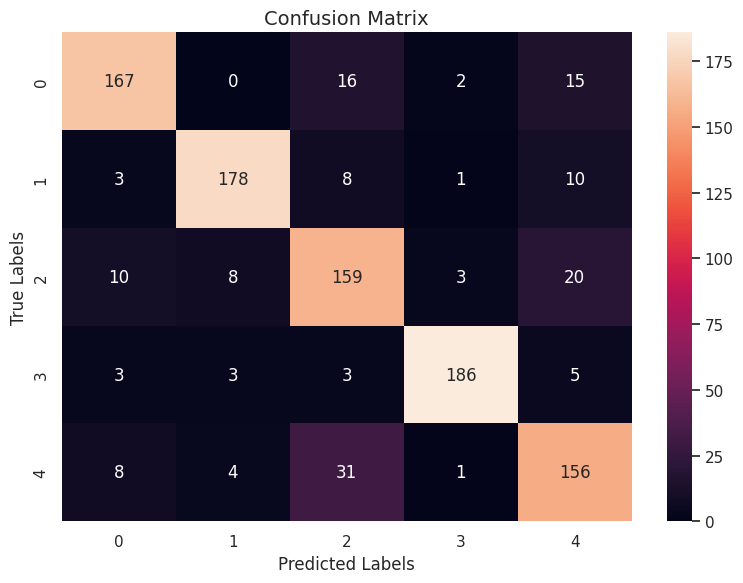

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       200
           1       0.92      0.89      0.91       200
           2       0.73      0.80      0.76       200
           3       0.96      0.93      0.95       200
           4       0.76      0.78      0.77       200

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000

Test Accuracy: 0.846
Test F1 Score: 0.848
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
2 jinaai/jina-embeddings-v3 - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
Feature Col

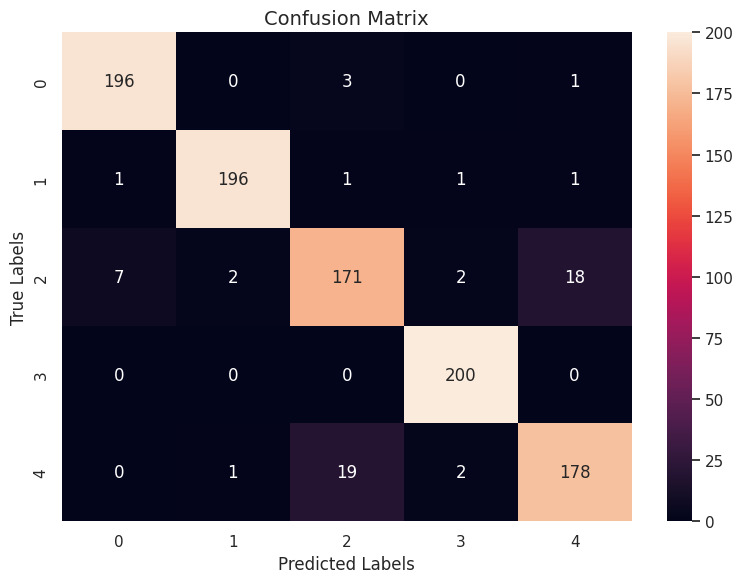

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       200
           1       0.98      0.98      0.98       200
           2       0.88      0.85      0.87       200
           3       0.98      1.00      0.99       200
           4       0.90      0.89      0.89       200

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000

Test Accuracy: 0.941
Test F1 Score: 0.941
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
3 intfloat/multilingual-e5-large-instruct - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim

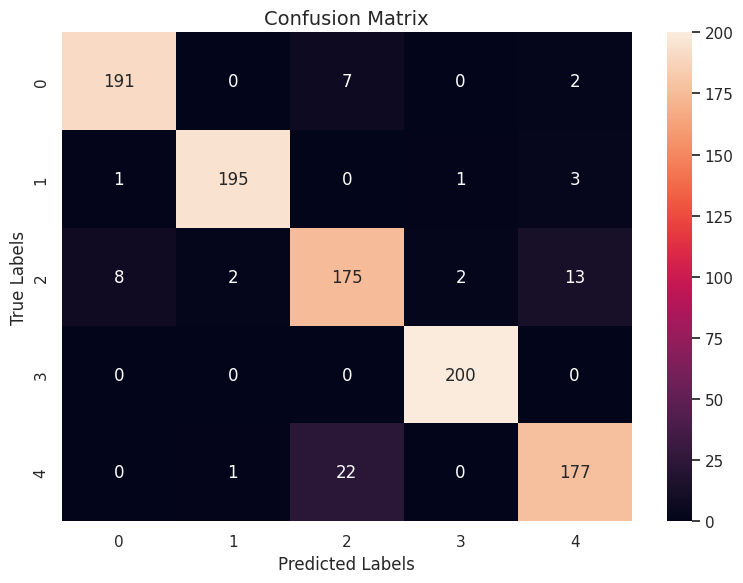

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       200
           1       0.98      0.97      0.98       200
           2       0.86      0.88      0.87       200
           3       0.99      1.00      0.99       200
           4       0.91      0.89      0.90       200

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000

Test Accuracy: 0.938
Test F1 Score: 0.938
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
4 BAAI/bge-m3 - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
Feature Columns: (1024) &

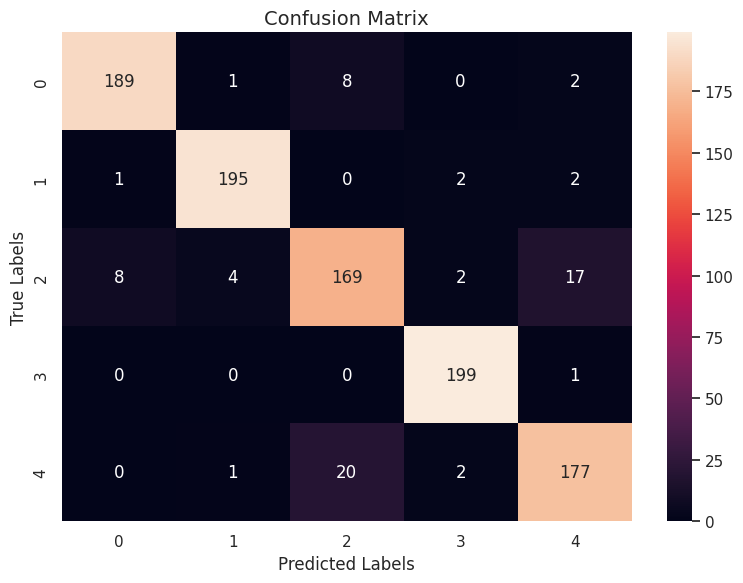

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       200
           1       0.97      0.97      0.97       200
           2       0.86      0.84      0.85       200
           3       0.97      0.99      0.98       200
           4       0.89      0.89      0.89       200

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000

Test Accuracy: 0.929
Test F1 Score: 0.929
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
5 thenlper/gte-large - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
Feature Columns: (

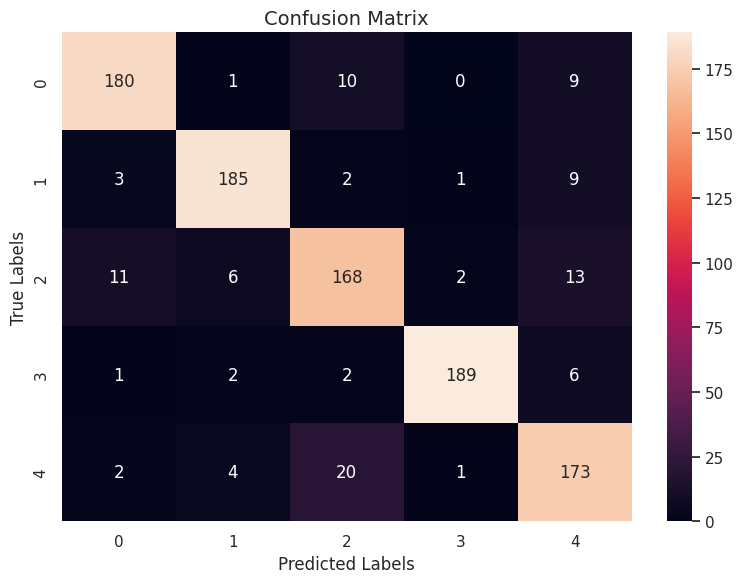

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       200
           1       0.93      0.93      0.93       200
           2       0.83      0.84      0.84       200
           3       0.98      0.94      0.96       200
           4       0.82      0.86      0.84       200

    accuracy                           0.90      1000
   macro avg       0.90      0.89      0.90      1000
weighted avg       0.90      0.90      0.90      1000

Test Accuracy: 0.895
Test F1 Score: 0.896
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
CPU times: user 47.5 s, sys: 6.52 s, total: 54 s
Wall time: 3min 21s


In [19]:
%%time

model_stats_svm = {}

for idx, df_emb_data in enumerate(df_emb_data_list):
    print("# " * 50)
    print(f"{idx+1} {embedding_models[idx]} - Embedding Data Shape: {df_emb_data.shape}")
    print("# " * 50)
    print("Target Unique Values:", df_emb_data['Kategori'].unique())

    feature_columns = [col for col in df_emb_data.columns if 'embedding_' in col]
    print(f"Feature Columns: ({len(feature_columns)}) & {feature_columns[0:5]} ... {feature_columns[len(feature_columns)-5:]}")

    X = df_emb_data[feature_columns].values
    # y = df_emb_data_1['Kategori'].values
    y_encoded = label_encoder.fit_transform(df_emb_data['Kategori'].values)
    y = y_encoded
    print(f"X Shape: {X.shape} & y Shape: {y.shape}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42, stratify=y)
    print(f"X_Train Shape: {X_train.shape} & X_Test Shape: {X_test.shape} & Y_Train Shape: {y_train.shape} & Y_Test Shape: {y_test.shape}")

    X_train.shape, y_train.shape, X_test.shape, y_test.shape

    # Parametre Values for SVM Model
    svm_param_dist = {
        'C': np.logspace(-2, 2, 10),
        'gamma': np.logspace(-3, 1, 10),
        'kernel': ['rbf', 'linear']
    }

    # SVM Classifier Model
    svm_clf = SVC()

    # SVM Model with Random Search
    svm_random_model = RandomizedSearchCV(estimator=svm_clf,
                                          param_distributions=svm_param_dist,
                                          n_iter=10,
                                          cv=kf,
                                          scoring='accuracy',
                                          n_jobs=-1,
                                          random_state=23)

    svm_model = svm_random_model.fit(X_train, y_train)

    svm_random_model_best_estimator = svm_model.best_estimator_
    svm_random_model_best_params = svm_model.best_params_
    svm_random_model_best_score = svm_model.best_score_

    # Model Performans Evaluate
    # svm_random_scores = cross_val_score(svm_random_model_best_estimator, X_train, y_train, cv=kf, scoring='accuracy')

    means = svm_model.cv_results_['mean_test_score']
    stds = svm_model.cv_results_['std_test_score']
    params = svm_model.cv_results_['params']

    print()
    print("Id", "  Mean", "    StDev", "\t\t\t\t\tParams")
    for idx, (mean, stdev, param) in enumerate(zip(means, stds, params)):
        print("%d %f (%f) with: %r" % (idx+1, mean, stdev, param))

    # Summarize Results
    print()
    print("Best: %f using %s" % (svm_random_model_best_score, svm_random_model_best_params))
    print()

    y_pred = svm_random_model_best_estimator.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g');
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)

    # Set labels and title
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.tight_layout()
    plt.show()    

    print("Classification Report:")
    print(classification_report(y_true=y_test, y_pred=y_pred))

    acc_score = round(accuracy_score(y_true=y_test, y_pred=y_pred), 3)
    f1_score_ = round(f1_score(y_true=y_test, y_pred=y_pred, average='macro'), 3)
    print("Test Accuracy:", acc_score)
    print("Test F1 Score:", f1_score_)
    
    model_stats_svm[f"Emb_{idx+1}"] = {
        "train_best_score": svm_random_model_best_score,
        "train_best_params": svm_random_model_best_params,
        "test_accuracy": acc_score,
        "test_f1": f1_score_,
        "y_test": y_test,
        "y_pred": y_pred,
    }
    print("* " * 50)

### Model 2: Random Forest Model

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
1 sentence-transformers/all-MiniLM-L12-v2 - Embedding Data Shape: (7500, 386)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
Feature Columns: (384) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_379', 'embedding_380', 'embedding_381', 'embedding_382', 'embedding_383']
X Shape: (7500, 384) & y Shape: (7500,)
X_Train Shape: (6500, 384) & X_Test Shape: (1000, 384) & Y_Train Shape: (6500,) & Y_Test Shape: (1000,)

Id   Mean     StDev 					Params
1 0.741077 (0.009096) with: {'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 10, 'bootstrap': True}
2 0.770615 (0.013416) with: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 20, 'bootstrap': False}
3 0.771385 (0.012

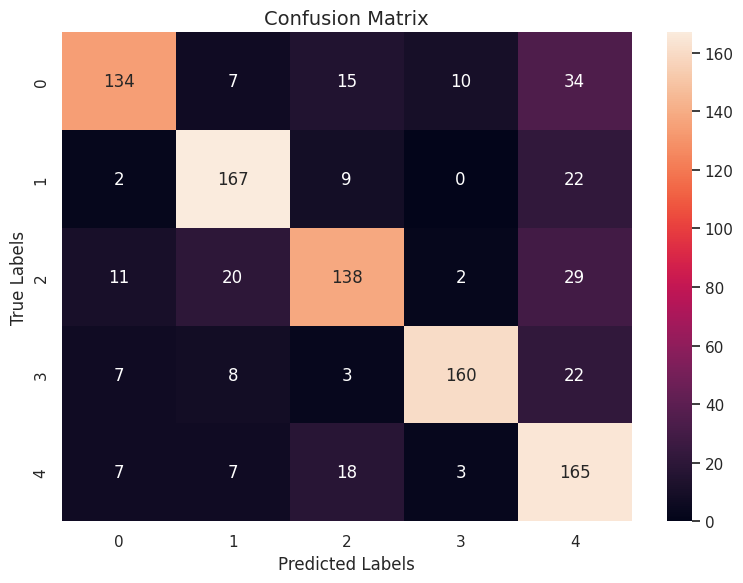

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.67      0.74       200
           1       0.80      0.83      0.82       200
           2       0.75      0.69      0.72       200
           3       0.91      0.80      0.85       200
           4       0.61      0.82      0.70       200

    accuracy                           0.76      1000
   macro avg       0.78      0.76      0.77      1000
weighted avg       0.78      0.76      0.77      1000

Test Accuracy: 0.764
Test F1 Score: 0.766
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
2 jinaai/jina-embeddings-v3 - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
Feature Col

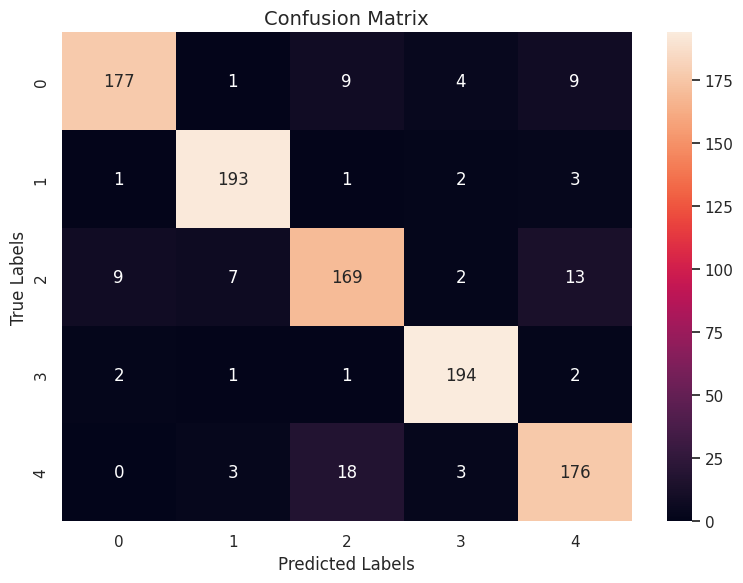

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       200
           1       0.94      0.96      0.95       200
           2       0.85      0.84      0.85       200
           3       0.95      0.97      0.96       200
           4       0.87      0.88      0.87       200

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

Test Accuracy: 0.909
Test F1 Score: 0.909
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
3 intfloat/multilingual-e5-large-instruct - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim

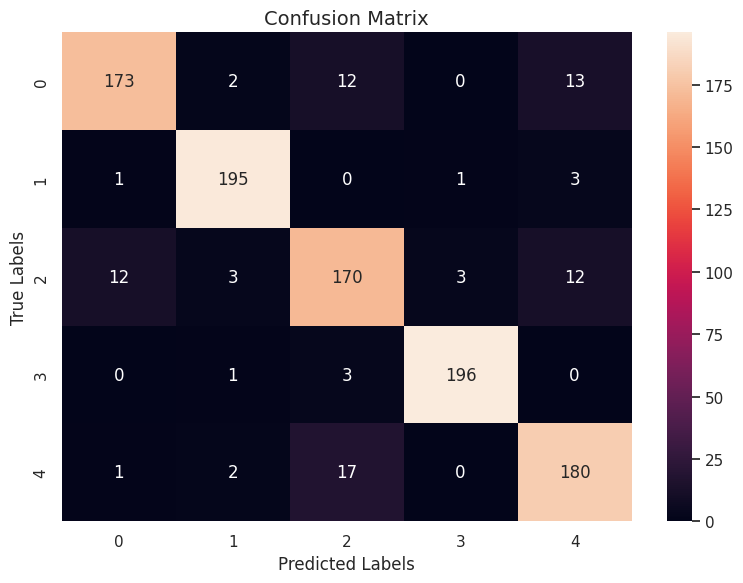

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       200
           1       0.96      0.97      0.97       200
           2       0.84      0.85      0.85       200
           3       0.98      0.98      0.98       200
           4       0.87      0.90      0.88       200

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

Test Accuracy: 0.914
Test F1 Score: 0.914
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
4 BAAI/bge-m3 - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
Feature Columns: (1024) &

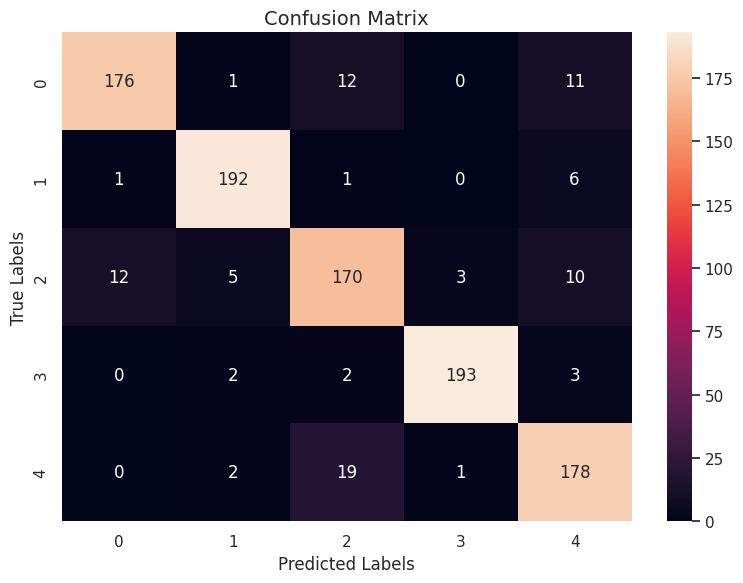

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       200
           1       0.95      0.96      0.96       200
           2       0.83      0.85      0.84       200
           3       0.98      0.96      0.97       200
           4       0.86      0.89      0.87       200

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

Test Accuracy: 0.909
Test F1 Score: 0.909
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
5 thenlper/gte-large - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
Feature Columns: (

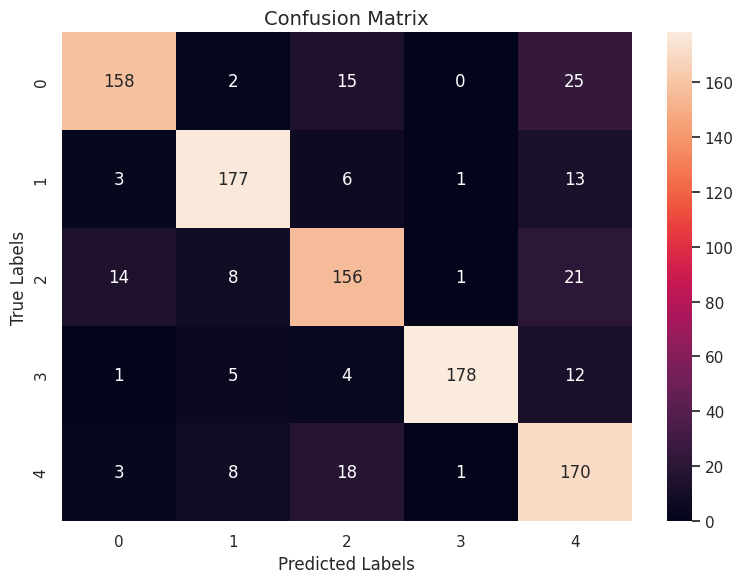

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       200
           1       0.89      0.89      0.89       200
           2       0.78      0.78      0.78       200
           3       0.98      0.89      0.93       200
           4       0.71      0.85      0.77       200

    accuracy                           0.84      1000
   macro avg       0.85      0.84      0.84      1000
weighted avg       0.85      0.84      0.84      1000

Test Accuracy: 0.839
Test F1 Score: 0.841
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
CPU times: user 7min 43s, sys: 2.81 s, total: 7min 46s
Wall time: 17min 8s


In [20]:
%%time

model_stats_rf = {}

for idx, df_emb_data in enumerate(df_emb_data_list):
    print("# " * 50)
    print(f"{idx+1} {embedding_models[idx]} - Embedding Data Shape: {df_emb_data.shape}")
    print("# " * 50)
    print("Target Unique Values:", df_emb_data['Kategori'].unique())

    feature_columns = [col for col in df_emb_data.columns if 'embedding_' in col]
    print(f"Feature Columns: ({len(feature_columns)}) & {feature_columns[0:5]} ... {feature_columns[len(feature_columns)-5:]}")

    X = df_emb_data[feature_columns].values
    # y = df_emb_data['Kategori'].values
    y_encoded = label_encoder.fit_transform(df_emb_data['Kategori'].values)
    y = y_encoded
    print(f"X Shape: {X.shape} & y Shape: {y.shape}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42, stratify=y)
    print(f"X_Train Shape: {X_train.shape} & X_Test Shape: {X_test.shape} & Y_Train Shape: {y_train.shape} & Y_Test Shape: {y_test.shape}")

    X_train.shape, y_train.shape, X_test.shape, y_test.shape

    # Parametre Values for RF Model
    rf_param_dist = {
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [10, 20, 30, 50, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        # 'max_features': ['auto', 'sqrt', 'log2', None],
        'bootstrap': [True, False],
    }

    # RF Classifier Model
    rf_clf = RandomForestClassifier()

    # RF Model with Random Search
    rf_random_model = RandomizedSearchCV(estimator=rf_clf,
                                         param_distributions=rf_param_dist,
                                         n_iter=10,
                                         cv=kf,
                                         scoring='accuracy',
                                         n_jobs=-1,
                                         # verbose=2,
                                         random_state=23)

    rf_model = rf_random_model.fit(X_train, y_train)

    rf_random_model_best_estimator = rf_model.best_estimator_
    rf_random_model_best_params = rf_model.best_params_
    rf_random_model_best_score = rf_model.best_score_

    means = rf_model.cv_results_['mean_test_score']
    stds = rf_model.cv_results_['std_test_score']
    params = rf_model.cv_results_['params']

    print()
    print("Id", "  Mean", "    StDev", "\t\t\t\t\tParams")
    for idx, (mean, stdev, param) in enumerate(zip(means, stds, params)):
        print("%d %f (%f) with: %r" % (idx+1, mean, stdev, param))

    # Summarize Results
    print()
    print("Best: %f using %s" % (rf_random_model_best_score, rf_random_model_best_params))
    print()

    y_pred = rf_random_model_best_estimator.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g');
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)

    # Set labels and title
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.tight_layout()
    plt.show()    

    print("Classification Report:")
    print(classification_report(y_true=y_test, y_pred=y_pred))

    acc_score = round(accuracy_score(y_true=y_test, y_pred=y_pred), 3)
    f1_score_ = round(f1_score(y_true=y_test, y_pred=y_pred, average='macro'), 3)
    print("Test Accuracy:", acc_score)
    print("Test F1 Score:", f1_score_)
    
    model_stats_rf[f"Emb_{idx+1}"] = {
        "train_best_score": rf_random_model_best_score,
        "train_best_params": rf_random_model_best_params,
        "test_accuracy": acc_score,
        "test_f1": f1_score_,
        "y_test": y_test,
        "y_pred": y_pred,
    }
    print("* " * 50)
    # break

### Model 3: Multi Layer Perceptron (MLP)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
1 sentence-transformers/all-MiniLM-L12-v2 - Embedding Data Shape: (7500, 386)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
Feature Columns: (384) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_379', 'embedding_380', 'embedding_381', 'embedding_382', 'embedding_383']
X Shape: (7500, 384) & y Shape: (7500,)
X_Train Shape: (6500, 384) & X_Test Shape: (1000, 384) & Y_Train Shape: (6500,) & Y_Test Shape: (1000,)


/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than s


Id   Mean     StDev 					Params
1 0.817385 (0.006298) with: {'solver': 'sgd', 'max_iter': 150, 'learning_rate': 'constant', 'hidden_layer_sizes': (10,), 'batch_size': 16, 'alpha': 0.001, 'activation': 'tanh'}
2 0.210308 (0.007226) with: {'solver': 'sgd', 'max_iter': 200, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (10,), 'batch_size': 64, 'alpha': 0.01, 'activation': 'logistic'}
3 0.200000 (0.009295) with: {'solver': 'sgd', 'max_iter': 100, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (10,), 'batch_size': 64, 'alpha': 0.001, 'activation': 'logistic'}
4 0.797077 (0.009002) with: {'solver': 'sgd', 'max_iter': 150, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (10,), 'batch_size': 32, 'alpha': 0.001, 'activation': 'tanh'}
5 0.748000 (0.007323) with: {'solver': 'sgd', 'max_iter': 100, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (5,), 'batch_size': 32, 'alpha': 0.001, 'activation': 'relu'}
6 0.724615 (0.006966) with: {'solver': 'sgd', 'max_iter': 100, 'learning

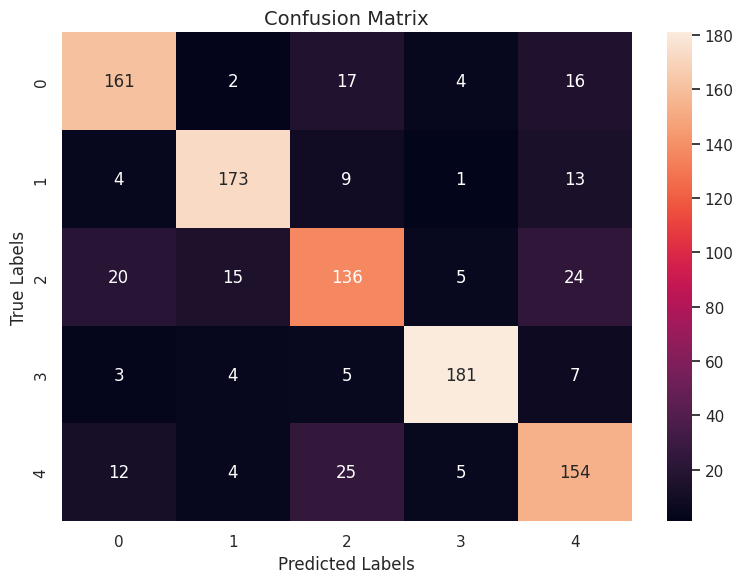

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       200
           1       0.87      0.86      0.87       200
           2       0.71      0.68      0.69       200
           3       0.92      0.91      0.91       200
           4       0.72      0.77      0.74       200

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000

Test Accuracy: 0.805
Test F1 Score: 0.805
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
2 jinaai/jina-embeddings-v3 - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
Feature Col

/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than s


Id   Mean     StDev 					Params
1 0.932308 (0.004485) with: {'solver': 'sgd', 'max_iter': 150, 'learning_rate': 'constant', 'hidden_layer_sizes': (10,), 'batch_size': 16, 'alpha': 0.001, 'activation': 'tanh'}
2 0.208769 (0.016531) with: {'solver': 'sgd', 'max_iter': 200, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (10,), 'batch_size': 64, 'alpha': 0.01, 'activation': 'logistic'}
3 0.202154 (0.010359) with: {'solver': 'sgd', 'max_iter': 100, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (10,), 'batch_size': 64, 'alpha': 0.001, 'activation': 'logistic'}
4 0.933231 (0.003419) with: {'solver': 'sgd', 'max_iter': 150, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (10,), 'batch_size': 32, 'alpha': 0.001, 'activation': 'tanh'}
5 0.919846 (0.006835) with: {'solver': 'sgd', 'max_iter': 100, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (5,), 'batch_size': 32, 'alpha': 0.001, 'activation': 'relu'}
6 0.916000 (0.004389) with: {'solver': 'sgd', 'max_iter': 100, 'learning

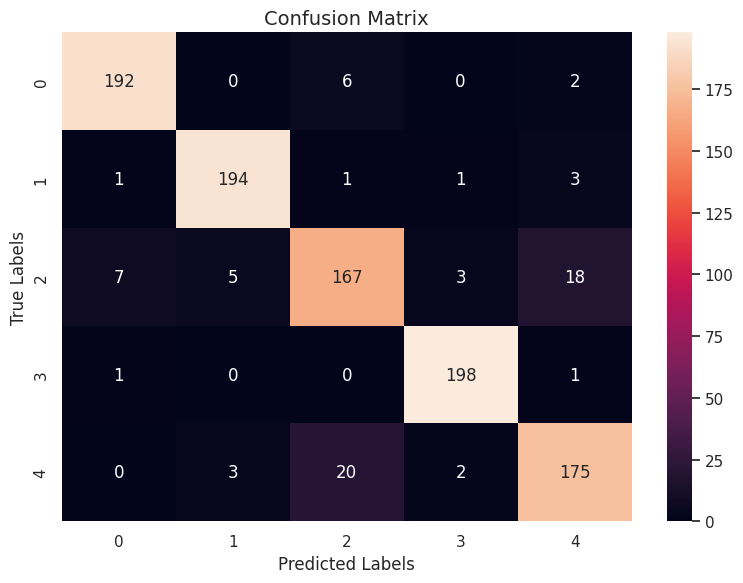

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       200
           1       0.96      0.97      0.97       200
           2       0.86      0.83      0.85       200
           3       0.97      0.99      0.98       200
           4       0.88      0.88      0.88       200

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000

Test Accuracy: 0.926
Test F1 Score: 0.926
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
3 intfloat/multilingual-e5-large-instruct - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim

/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than s


Id   Mean     StDev 					Params
1 0.933538 (0.005093) with: {'solver': 'sgd', 'max_iter': 150, 'learning_rate': 'constant', 'hidden_layer_sizes': (10,), 'batch_size': 16, 'alpha': 0.001, 'activation': 'tanh'}
2 0.192769 (0.009822) with: {'solver': 'sgd', 'max_iter': 200, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (10,), 'batch_size': 64, 'alpha': 0.01, 'activation': 'logistic'}
3 0.196154 (0.014756) with: {'solver': 'sgd', 'max_iter': 100, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (10,), 'batch_size': 64, 'alpha': 0.001, 'activation': 'logistic'}
4 0.928000 (0.003849) with: {'solver': 'sgd', 'max_iter': 150, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (10,), 'batch_size': 32, 'alpha': 0.001, 'activation': 'tanh'}
5 0.879538 (0.028611) with: {'solver': 'sgd', 'max_iter': 100, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (5,), 'batch_size': 32, 'alpha': 0.001, 'activation': 'relu'}
6 0.897077 (0.006660) with: {'solver': 'sgd', 'max_iter': 100, 'learning

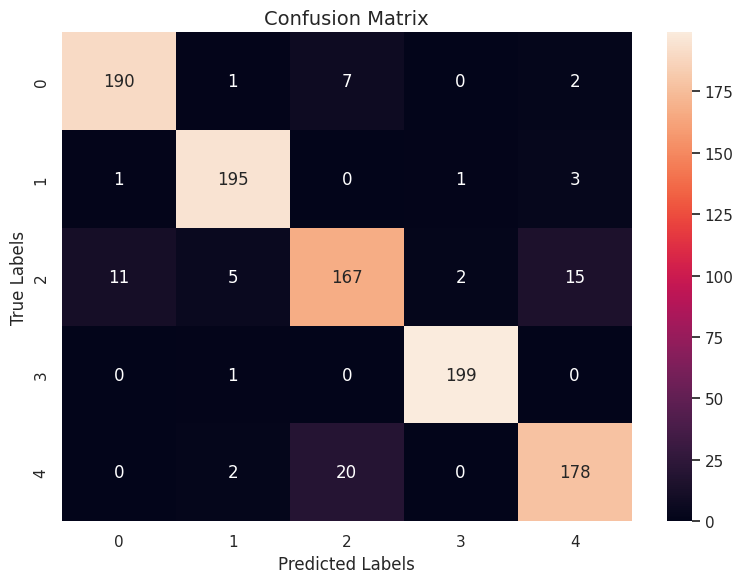

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       200
           1       0.96      0.97      0.97       200
           2       0.86      0.83      0.85       200
           3       0.99      0.99      0.99       200
           4       0.90      0.89      0.89       200

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000

Test Accuracy: 0.929
Test F1 Score: 0.929
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
4 BAAI/bge-m3 - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
Feature Columns: (1024) &

/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than s


Id   Mean     StDev 					Params
1 0.931846 (0.003249) with: {'solver': 'sgd', 'max_iter': 150, 'learning_rate': 'constant', 'hidden_layer_sizes': (10,), 'batch_size': 16, 'alpha': 0.001, 'activation': 'tanh'}
2 0.198000 (0.006628) with: {'solver': 'sgd', 'max_iter': 200, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (10,), 'batch_size': 64, 'alpha': 0.01, 'activation': 'logistic'}
3 0.193231 (0.006498) with: {'solver': 'sgd', 'max_iter': 100, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (10,), 'batch_size': 64, 'alpha': 0.001, 'activation': 'logistic'}
4 0.928462 (0.003335) with: {'solver': 'sgd', 'max_iter': 150, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (10,), 'batch_size': 32, 'alpha': 0.001, 'activation': 'tanh'}
5 0.916000 (0.008749) with: {'solver': 'sgd', 'max_iter': 100, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (5,), 'batch_size': 32, 'alpha': 0.001, 'activation': 'relu'}
6 0.912769 (0.006574) with: {'solver': 'sgd', 'max_iter': 100, 'learning

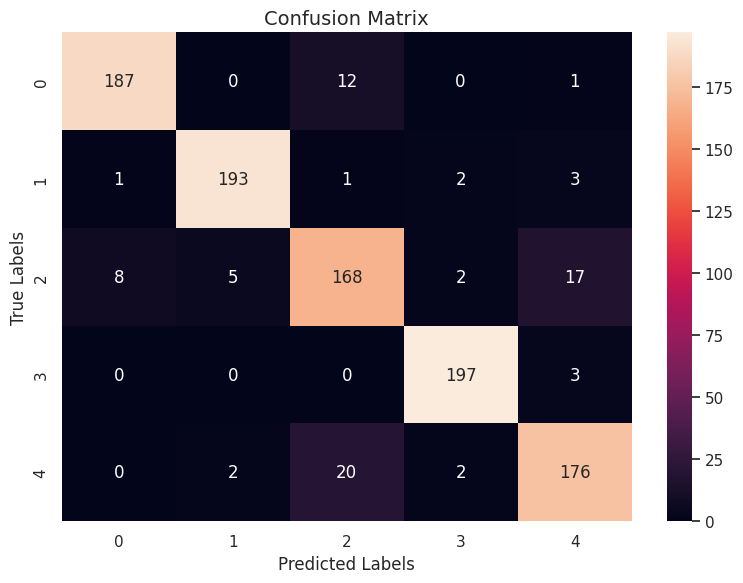

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       200
           1       0.96      0.96      0.96       200
           2       0.84      0.84      0.84       200
           3       0.97      0.98      0.98       200
           4       0.88      0.88      0.88       200

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

Test Accuracy: 0.921
Test F1 Score: 0.921
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
5 thenlper/gte-large - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
Feature Columns: (

/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than s


Id   Mean     StDev 					Params
1 0.859846 (0.012820) with: {'solver': 'sgd', 'max_iter': 150, 'learning_rate': 'constant', 'hidden_layer_sizes': (10,), 'batch_size': 16, 'alpha': 0.001, 'activation': 'tanh'}
2 0.198923 (0.008752) with: {'solver': 'sgd', 'max_iter': 200, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (10,), 'batch_size': 64, 'alpha': 0.01, 'activation': 'logistic'}
3 0.206308 (0.007320) with: {'solver': 'sgd', 'max_iter': 100, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (10,), 'batch_size': 64, 'alpha': 0.001, 'activation': 'logistic'}
4 0.834000 (0.009662) with: {'solver': 'sgd', 'max_iter': 150, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (10,), 'batch_size': 32, 'alpha': 0.001, 'activation': 'tanh'}
5 0.777692 (0.015652) with: {'solver': 'sgd', 'max_iter': 100, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (5,), 'batch_size': 32, 'alpha': 0.001, 'activation': 'relu'}
6 0.761077 (0.013364) with: {'solver': 'sgd', 'max_iter': 100, 'learning

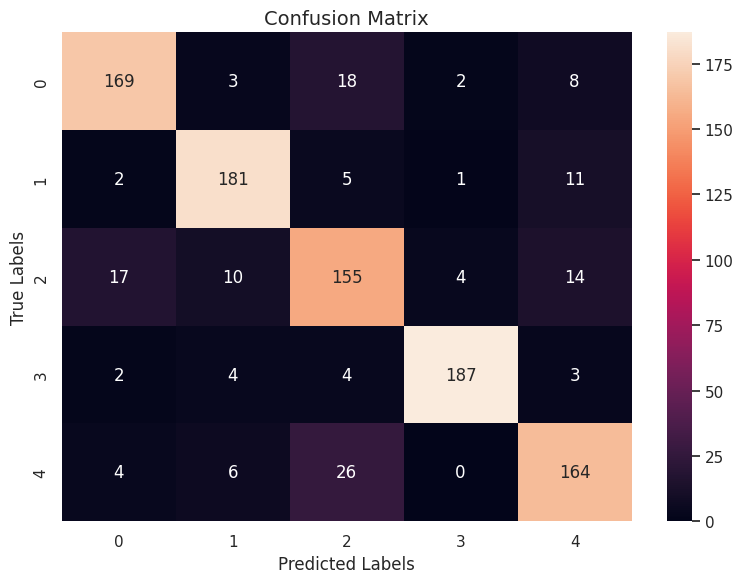

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       200
           1       0.89      0.91      0.90       200
           2       0.75      0.78      0.76       200
           3       0.96      0.94      0.95       200
           4       0.82      0.82      0.82       200

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000

Test Accuracy: 0.856
Test F1 Score: 0.857
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
CPU times: user 13min 25s, sys: 52min 11s, total: 1h 5min 36s
Wall time: 2min 52s


In [21]:
%%time

model_stats_mlp = {}

for idx, df_emb_data in enumerate(df_emb_data_list):
    print("# " * 50)
    print(f"{idx+1} {embedding_models[idx]} - Embedding Data Shape: {df_emb_data.shape}")
    print("# " * 50)
    print("Target Unique Values:", df_emb_data['Kategori'].unique())

    feature_columns = [col for col in df_emb_data.columns if 'embedding_' in col]
    print(f"Feature Columns: ({len(feature_columns)}) & {feature_columns[0:5]} ... {feature_columns[len(feature_columns)-5:]}")

    X = df_emb_data[feature_columns].values
    # y = df_emb_data['Kategori'].values
    y_encoded = label_encoder.fit_transform(df_emb_data['Kategori'].values)
    y = y_encoded
    print(f"X Shape: {X.shape} & y Shape: {y.shape}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42, stratify=y)
    print(f"X_Train Shape: {X_train.shape} & X_Test Shape: {X_test.shape} & Y_Train Shape: {y_train.shape} & Y_Test Shape: {y_test.shape}")

    X_train.shape, y_train.shape, X_test.shape, y_test.shape

    # Parametre Values for MLP Model
    mlp_param_dist = {
        'hidden_layer_sizes': [(5, ), (10, ), (15, )],
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['sgd',],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'max_iter': [100, 150, 200],
        'batch_size': [16, 32, 64, X_train.shape[0]],
        'alpha': [1e-4, 1e-3, 1e-2],
    }

    # MLP Classifier Model
    mlp_clf = MLPClassifier()

    # Multilayer Perceptron Model with Random Search
    mlp_random_model = RandomizedSearchCV(estimator=mlp_clf,
                                          param_distributions=mlp_param_dist,
                                          n_iter=10,
                                          cv=kf,
                                          scoring='accuracy',
                                          n_jobs=-1,
                                          random_state=23)

    mlp_model = mlp_random_model.fit(X_train, y_train)

    mlp_random_model_best_estimator = mlp_model.best_estimator_
    mlp_random_model_best_params = mlp_model.best_params_
    mlp_random_model_best_score = mlp_model.best_score_

    means = mlp_model.cv_results_['mean_test_score']
    stds = mlp_model.cv_results_['std_test_score']
    params = mlp_model.cv_results_['params']

    print()
    print("Id", "  Mean", "    StDev", "\t\t\t\t\tParams")
    for idx, (mean, stdev, param) in enumerate(zip(means, stds, params)):
        print("%d %f (%f) with: %r" % (idx+1, mean, stdev, param))

    # Summarize Results
    print()
    print("Best: %f using %s" % (mlp_random_model_best_score, mlp_random_model_best_params))
    print()

    y_pred = mlp_random_model_best_estimator.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g');
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)

    # Set labels and title
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.tight_layout()
    plt.show()    

    print("Classification Report:")
    print(classification_report(y_true=y_test, y_pred=y_pred))

    acc_score = round(accuracy_score(y_true=y_test, y_pred=y_pred), 3)
    f1_score_ = round(f1_score(y_true=y_test, y_pred=y_pred, average='macro'), 3)
    print("Test Accuracy:", acc_score)
    print("Test F1 Score:", f1_score_)
    
    model_stats_mlp[f"Emb_{idx+1}"] = {
        "train_best_score": mlp_random_model_best_score,
        "train_best_params": mlp_random_model_best_params,
        "test_accuracy": acc_score,
        "test_f1": f1_score_,
        "y_test": y_test,
        "y_pred": y_pred,
    }
    print("* " * 50)
    # break

## Result & Conclusion

In [22]:
# Model Stats Serialize

with open(os.path.join(MDL_STATS_PATH, 'news_model_stats_svm_data.pickle'), 'wb') as handle:
    pickle.dump(model_stats_svm, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(MDL_STATS_PATH, 'news_model_stats_rf_data.pickle'), 'wb') as handle:
    pickle.dump(model_stats_rf, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(MDL_STATS_PATH, 'news_model_stats_mlp_data.pickle'), 'wb') as handle:
    pickle.dump(model_stats_mlp, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Model Stats Deserialize
with open(os.path.join(MDL_STATS_PATH, 'news_model_stats_svm_data.pickle'), 'rb') as handle:
    model_stats_svm_data = pickle.load(handle)

with open(os.path.join(MDL_STATS_PATH, 'news_model_stats_rf_data.pickle'), 'rb') as handle:
    model_stats_rf_data = pickle.load(handle)

with open(os.path.join(MDL_STATS_PATH, 'news_model_stats_mlp_data.pickle'), 'rb') as handle:
    model_stats_mlp_data = pickle.load(handle)

### Performance

In [ ]:
for idx, emb in enumerate(embedding_models_dict):
    print(f"Embedding Method: {emb}")
    print(f"\tSVM Model\t: Test Accuracy: {model_stats_svm_data[f"Emb_{idx+1}"]["test_accuracy"]} & Test F1 Score:{model_stats_svm_data[f"Emb_{idx+1}"]["test_f1"]}")
    print(f"\tRF Model\t: Test Accuracy: {model_stats_rf_data[f"Emb_{idx+1}"]["test_accuracy"]} & Test F1 Score:{model_stats_rf_data[f"Emb_{idx+1}"]["test_f1"]}")
    print(f"\tMLP Model\t: Test Accuracy: {model_stats_mlp_data[f"Emb_{idx+1}"]["test_accuracy"]} & Test F1 Score:{model_stats_mlp_data[f"Emb_{idx+1}"]["test_f1"]}")
    print("* " * 35)

### Aynı Temsil Yöntemi (5)

In [ ]:
# AllMini->SVM
# AllMini->RF
# AllMini->MLP

# Jina->SVM
# Jina->RF
# Jina->MLP

In [ ]:
df_same_emb_all_model = pd.DataFrame()

for idx, emb in enumerate(embedding_models_dict):
    # print(f"Embedding Method: {emb}")
    # Y Test Real
    # array0 = y_test
    # array0 = np.insert(array0.astype(object), 0, "-")
    # array0 = np.insert(array0.astype(object), 1, "-")
    # array0 = np.insert(array0.astype(object), 2, "YReal")
    
    # Y Pred 
    array1 = model_stats_svm_data[f"Emb_{idx+1}"]["y_pred"]
    array1 = np.insert(array1.astype(object), 0, f"{emb}")
    array1 = np.insert(array1.astype(object), 1, "SVM")
    array1 = np.insert(array1.astype(object), 2, "YPred")
    
    # Y Pred 
    array2 = model_stats_rf_data[f"Emb_{idx+1}"]["y_pred"]
    array2 = np.insert(array2.astype(object), 0, f"{emb}")
    array2 = np.insert(array2.astype(object), 1, "RF")
    array2 = np.insert(array2.astype(object), 2, "YPred")
    
    # Y Pred 
    array3 = model_stats_mlp_data[f"Emb_{idx+1}"]["y_pred"]
    array3 = np.insert(array3.astype(object), 0, f"{emb}")
    array3 = np.insert(array3.astype(object), 1, "MLP")
    array3 = np.insert(array3.astype(object), 2, "YPred")
    
    # df_same_emb_all_model_tmp = pd.DataFrame([array0, array1, array2, array3])
    df_same_emb_all_model_tmp = pd.DataFrame([array1, array2, array3])
    df_same_emb_all_model = pd.concat([df_same_emb_all_model, df_same_emb_all_model_tmp])

df_same_emb_all_model.rename(columns={0:"EmbeddingMethod", 1:"Model", 2:"Y_Real/Test"}, inplace=True)
df_same_emb_all_model.reset_index(drop=True, inplace=True)
df_same_emb_all_model

#### All Mini LM L12 v2

In [ ]:
df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']=="All Mini LM L12 v2") & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

In [ ]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.2%}")

#### Jina Embeddings v3

In [ ]:
df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']=="Jina Embeddings v3") & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

In [ ]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.2%}")

#### Int Float Multilingual E5 Large Instruct

In [ ]:
df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']=="Int Float Multilingual E5 Large Instruct") & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

In [ ]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.2%}")

#### BAAI BGE M

In [ ]:
df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']=="BAAI BGE M3") & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

In [ ]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.2%}")

#### Thenlper Gte Large

In [ ]:
df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']=="Thenlper Gte Large") & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

In [ ]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions
print(f"Doğruluk Oranı: {accuracy:.2%}")

#### All Embedding Method Result

In [ ]:
for idx, emb in enumerate(embedding_models_dict):
    # print(f"Embedding Method: {emb}")
    df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']==emb) & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
    modes = df.mode().iloc[0]
    df.loc["Mode"] = modes
    df.loc["YReal"] = y_test
    # df
    
    correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
    total_predictions = df.shape[1]
    accuracy = correct_predictions / total_predictions
    
    print(f"Embedding Method: {emb:<40} \t\t\t Doğruluk Oranı: {accuracy:.3}")

#### Embedding x Models vs Ensemble Result

In [ ]:
for idx, emb in enumerate(embedding_models_dict):
    print(f"Embedding Method: {emb}")
    print(f"\tSVM Model\t: Test Accuracy: {model_stats_svm_data[f"Emb_{idx+1}"]["test_accuracy"]} & Test F1 Score:{model_stats_svm_data[f"Emb_{idx+1}"]["test_f1"]}")
    print(f"\tRF Model\t: Test Accuracy: {model_stats_rf_data[f"Emb_{idx+1}"]["test_accuracy"]} & Test F1 Score:{model_stats_rf_data[f"Emb_{idx+1}"]["test_f1"]}")
    print(f"\tMLP Model\t: Test Accuracy: {model_stats_mlp_data[f"Emb_{idx+1}"]["test_accuracy"]} & Test F1 Score:{model_stats_mlp_data[f"Emb_{idx+1}"]["test_f1"]}")
    
    df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']==emb) & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
    modes = df.mode().iloc[0]
    df.loc["Mode"] = modes
    df.loc["YReal"] = y_test
   
    correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
    total_predictions = df.shape[1]
    accuracy = correct_predictions / total_predictions
    
    print(f"\tEnsemble Model\t: Test Accuracy: {accuracy:.3}")
    print("* " * 35)

### Aynı Algoritma (3)

In [ ]:
for mdl in ["SVM", "RF", "MLP"]:
    if mdl == "SVM":
        model_stats_mdl_data = model_stats_svm_data
    elif mdl == "RF":
        model_stats_mdl_data = model_stats_rf_data
    else:
        model_stats_mdl_data = model_stats_mlp_data
    for idx, emb in enumerate(embedding_models_dict):
        print(f"Model: {mdl} Model \t Embedding Method: {emb:<45} Test Accuracy: {model_stats_mdl_data[f"Emb_{idx+1}"]["test_accuracy"]} & Test F1 Score:{model_stats_mdl_data[f"Emb_{idx+1}"]["test_f1"]}")
    print()

In [ ]:
df_same_mdl_all_emb = pd.DataFrame()

for mdl in ["SVM", "RF", "MLP"]:
    if mdl == "SVM":
        model_stats_mdl_data = model_stats_svm_data
    elif mdl == "RF":
        model_stats_mdl_data = model_stats_rf_data
    else:
        model_stats_mdl_data = model_stats_mlp_data

    for idx, emb in enumerate(embedding_models_dict):
        array1 = model_stats_mdl_data[f"Emb_{idx+1}"]["y_pred"]
        array1 = np.insert(array1.astype(object), 0, f"{mdl}")
        array1 = np.insert(array1.astype(object), 1, f"{emb}")
        array1 = np.insert(array1.astype(object), 2, "YPred")
        df_same_mdl_all_emb_tmp = pd.DataFrame([array1])
        df_same_mdl_all_emb = pd.concat([df_same_mdl_all_emb, df_same_mdl_all_emb_tmp])

df_same_mdl_all_emb.rename(columns={0:"Model", 1:"EmbeddingMethod", 2:"Y_Real/Test"}, inplace=True)
df_same_mdl_all_emb.reset_index(drop=True, inplace=True)
df_same_mdl_all_emb

#### SVM Model

In [ ]:
df = df_same_mdl_all_emb[(df_same_mdl_all_emb['Model']=="SVM") & (df_same_mdl_all_emb['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

#### RF Model

In [ ]:
df = df_same_mdl_all_emb[(df_same_mdl_all_emb['Model']=="RF") & (df_same_mdl_all_emb['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

#### MLP Model

In [ ]:
df = df_same_mdl_all_emb[(df_same_mdl_all_emb['Model']=="MLP") & (df_same_mdl_all_emb['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

#### All Models Result

In [ ]:
for idx, mdl in enumerate(["SVM", "RF", "MLP"]):
    # print(f"Embedding Method: {emb}")
    df = df_same_mdl_all_emb[(df_same_mdl_all_emb['Model']==mdl) & (df_same_mdl_all_emb['Y_Real/Test']=="YPred")].iloc[:, 3:]
    modes = df.mode().iloc[0]
    df.loc["Mode"] = modes
    df.loc["YReal"] = y_test
    # df
    
    correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
    total_predictions = df.shape[1]
    accuracy = correct_predictions / total_predictions
    
    print(f"Model: {mdl} \t\t\t Doğruluk Oranı: {accuracy:.3}")

#### Model x Embeddings vs Ensemble Result

In [ ]:
for mdl in ["SVM", "RF", "MLP"]:
    if mdl == "SVM":
        model_stats_mdl_data = model_stats_svm_data
    elif mdl == "RF":
        model_stats_mdl_data = model_stats_rf_data
    else:
        model_stats_mdl_data = model_stats_mlp_data

    print(f"Model Name: {mdl}")
    for idx, emb in enumerate(embedding_models_dict):        
        print(f"\tEmbedding Method: {emb:<45}Test Accuracy: {model_stats_mdl_data[f"Emb_{idx+1}"]["test_accuracy"]} & Test F1 Score:{model_stats_mdl_data[f"Emb_{idx+1}"]["test_f1"]}")
        df = df_same_mdl_all_emb[(df_same_mdl_all_emb['Model']==mdl) & (df_same_mdl_all_emb['Y_Real/Test']=="YPred")].iloc[:, 3:]
        modes = df.mode().iloc[0]
        df.loc["Mode"] = modes
        df.loc["YReal"] = y_test
       
        correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
        total_predictions = df.shape[1]
        accuracy = correct_predictions / total_predictions
        
    print(f"\tEmbedding Method: {"Ensemble":<45}Test Accuracy: {accuracy}")
    print("* " * 35)

### 1 Test Sample için 15 Sonuc Temsil(5) x Algoritm(3)

In [ ]:
model_stats_svm_data
model_stats_rf_data
model_stats_mlp_data.keys()
model_stats_mdl_data[f"Emb_{idx+1}"]

for idx, emb in enumerate(embedding_models_dict.keys()):
    model_stats_svm_data[f"Emb_{idx+1}"]["y_pred"]
    model_stats_rf_data[f"Emb_{idx+1}"]["y_pred"]
    model_stats_mlp_data[f"Emb_{idx+1}"]["y_pred"]

In [ ]:
# model_stats_svm_data

In [ ]:
df_same_mdl_all_emb = pd.DataFrame()

for mdl in ["SVM", "RF", "MLP"]:
    if mdl == "SVM":
        model_stats_mdl_data = model_stats_svm_data
    elif mdl == "RF":
        model_stats_mdl_data = model_stats_rf_data
    else:
        model_stats_mdl_data = model_stats_mlp_data

    for idx, emb in enumerate(embedding_models_dict):
        array1 = model_stats_mdl_data[f"Emb_{idx+1}"]["y_pred"]
        array1 = np.insert(array1.astype(object), 0, f"{mdl}")
        array1 = np.insert(array1.astype(object), 1, f"{emb}")
        array1 = np.insert(array1.astype(object), 2, "YPred")
        df_same_mdl_all_emb_tmp = pd.DataFrame([array1])
        df_same_mdl_all_emb = pd.concat([df_same_mdl_all_emb, df_same_mdl_all_emb_tmp])

df_same_mdl_all_emb.rename(columns={0:"Model", 1:"EmbeddingMethod", 2:"Y_Real/Test"}, inplace=True)

array0 = y_test
array0 = np.insert(array0.astype(object), 0, "No Model Name")
array0 = np.insert(array0.astype(object), 1, "No Emb. Method")
array0 = np.insert(array0.astype(object), 2, "YReal")

df_arr = pd.DataFrame([array0])
df_arr.rename(columns={0:"Model", 1:"EmbeddingMethod", 2:"Y_Real/Test"}, inplace=True)

# df_same_mdl_all_emb = pd.concat([df_same_mdl_all_emb, df_arr], ignore_index=True)
df_same_mdl_all_emb.reset_index(drop=True, inplace=True)
df_same_mdl_all_emb


df = df_same_mdl_all_emb.iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

In [ ]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.2%}")